# Multimodal RAG for video analytics with LlamaIndex

Constructing a RAG pipeline for text is relatively straightforward, thanks to the tools developed for parsing, indexing, and retrieving text data. However, adapting RAG models for video content presents a greater challenge. Videos combine visual, auditory, and textual elements, requiring more processing power and sophisticated video pipelines.

To build a truly multimodal search for videos, you need to work with different modalities of a video like spoken content, visual. In this notebook, we showcase a Multimodal RAG pipeline designed for video analytics. It utilizes Whisper model to convert spoken content to text, CLIP model to generate multimodal embeddings, and Vision Language model (VLM) to process retrieved images and text messages. The following picture illustrates how this pipeline is working.

![Multimodal RAG](https://github.com/user-attachments/assets/baef4914-5c07-432c-9363-1a0cb5944b09)

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Convert and Compress models](#Convert-and-Compress-models)
    - [ASR model](#ASR-model)
    - [CLIP model](#CLIP-model)
    - [VLM model](#VLM-model)
- [Download and process video](#Download-and-process-video)
    - [Initialize ASR](#Initialize-ASR)
- [Create the multi-modal index](#Create-the-multi-modal-index)
    - [Initialize CLIP](#Initialize-CLIP)
- [Search text and image embeddings](#Search-text-and-image-embeddings)
- [Generate final response using VLM](#Generate-final-response-using-VLM)
    - [Set the RAG prompt template](#Set-the-RAG-prompt-template)
    - [Initialize VLM](#Initialize-VLM)
- [Interactive Demo](#Interactive-Demo)

### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).


<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/multimodal-rag/multimodal-rag-llamaindex.ipynb" />


## Prerequisites

[back to top ⬆️](#Table-of-contents:)

install required packages and setup helper functions.

In [ ]:
%pip install -q "llama-index-core" "llama-index-embeddings-openvino>=0.4.1" "llama-index-multi-modal-llms-openvino" "llama-index-readers-file" \
    "llama-index-vector-stores-qdrant"  \
    "transformers>=4.45" \
    "moviepy==1.0.3" \
    "librosa" \
    "python-ffmpeg<=1.0.16" \
    "yt-dlp" \
    "open_clip_torch" \
    "gradio>=4.44.1" --extra-index-url https://download.pytorch.org/whl/cpu

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -q "git+https://github.com/huggingface/optimum-intel.git"

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import requests
from pathlib import Path

os.environ["GIT_CLONE_PROTECTION_ACTIVE"] = "false"

if not Path("notebook_utils.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
    open("notebook_utils.py", "w", encoding="utf-8").write(r.text)

## Convert and Compress models

[back to top ⬆️](#Table-of-contents:)

### ASR model

[back to top ⬆️](#Table-of-contents:)

In this example, we utilize [Distil-Whisper](https://huggingface.co/distil-whisper/distil-large-v2) to recognize the spoken content in video and generate text. Distil-Whisper is a distilled variant of the [Whisper](https://huggingface.co/openai/whisper-large-v2) model by OpenAI. The Distil-Whisper is proposed in the paper [Robust Knowledge Distillation via Large-Scale Pseudo Labelling](https://arxiv.org/abs/2311.00430). According to authors, compared to Whisper, Distil-Whisper runs in several times faster with 50% fewer parameters, while performing to within 1% word error rate (WER) on out-of-distribution evaluation data.
For more information about Distil-Whisper, please refer [Distil-Whisper notebook](../distil-whisper-asr).

In [4]:
asr_model_id = "distil-whisper/distil-large-v3"
asr_model_path = asr_model_id.split("/")[-1]

if not Path(asr_model_path).exists():
    !optimum-cli export openvino --model {asr_model_id} {asr_model_path}

### CLIP model

[back to top ⬆️](#Table-of-contents:)

In this example, CLIP model will help to generate the embedding vectors for both text and images. CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on various (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task.

CLIP uses a [ViT](https://arxiv.org/abs/2010.11929) like transformer to get visual features and a causal language model to get the text features. The text and visual features are then projected into a latent space with identical dimensions. The dot product between the projected image and text features is then used as a similarity score.

In [5]:
clip_model_id = "laion/CLIP-ViT-B-32-laion2B-s34B-b79K"
clip_model_path = clip_model_id.split("/")[-1]

if not Path(clip_model_path).exists():
    !optimum-cli export openvino -m {clip_model_id} {clip_model_path}

### VLM model

[back to top ⬆️](#Table-of-contents:)

Vision Language model (VLM) is used to generate final response regrading the context of images and texts retrieved from vector DB. It can help to understand the both language and image instructions to complete various real-world tasks. In this example, we select [Phi-3.5-Vision](https://huggingface.co/microsoft/Phi-3.5-vision-instruct) as VLM.

The Phi-3-Vision is a lightweight, state-of-the-art open multimodal model built upon datasets which include - synthetic data and filtered publicly available websites - with a focus on very high-quality, reasoning dense data both on text and vision. The model belongs to the Phi-3 model family, and the multimodal version comes with 128K context length (in tokens) it can support. The model underwent a rigorous enhancement process, incorporating both supervised fine-tuning and direct preference optimization to ensure precise instruction adherence and robust safety measures. More details about model can be found in [model blog post](https://azure.microsoft.com/en-us/blog/new-models-added-to-the-phi-3-family-available-on-microsoft-azure/), [technical report](https://aka.ms/phi3-tech-report), [Phi-3-cookbook](https://github.com/microsoft/Phi-3CookBook)

In [6]:
vlm_model_id = "microsoft/Phi-3.5-vision-instruct"
vlm_model_path = Path(vlm_model_id.split("/")[-1]) / "FP16"

if not vlm_model_path.exists():
    !optimum-cli export openvino --model {vlm_model_id} --weight-format fp16 {vlm_model_path} --trust-remote-code

In [7]:
import shutil
import nncf
import openvino as ov
import gc

core = ov.Core()

compression_config = {
    "mode": nncf.CompressWeightsMode.INT4_SYM,
    "group_size": 64,
    "ratio": 0.6,
}

compressed_model_path = vlm_model_path.parent / "INT4"
if not compressed_model_path.exists():
    ov_model = core.read_model(vlm_model_path / "openvino_language_model.xml")
    compressed_ov_model = nncf.compress_weights(ov_model, **compression_config)
    ov.save_model(
        compressed_ov_model,
        compressed_model_path / "openvino_language_model.xml",
    )
    del compressed_ov_model
    del ov_model
    gc.collect()
    for file_name in vlm_model_path.glob("*"):
        if file_name.name in [
            "openvino_language_model.xml",
            "openvino_language_model.bin",
        ]:
            continue
        shutil.copy(file_name, compressed_model_path)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


## Download and process video

[back to top ⬆️](#Table-of-contents:)

To begin, download an example video from YouTube and extract the audio and frame files from it.

In [8]:
video_url = "https://www.youtube.com/watch?v=d_qvLDhkg00"
output_video_path = "./video_data/"
output_folder = "./mixed_data/"
output_audio_path = "./mixed_data/output_audio.wav"

filepath = output_video_path + "input_vid.mp4"
Path(output_folder).mkdir(parents=True, exist_ok=True)

if not Path(filepath).exists():
    !yt-dlp {video_url} -f best -o {filepath}

### Initialize ASR

[back to top ⬆️](#Table-of-contents:)

Select inference device

In [9]:
from notebook_utils import device_widget

asr_device = device_widget(default="AUTO", exclude=["NPU"])

asr_device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

The Hugging Face Optimum API is a high-level API that enables us to convert and quantize models from the Hugging Face Transformers library to the OpenVINO™ IR format. For more details, refer to the [Hugging Face Optimum documentation](https://huggingface.co/docs/optimum/intel/inference).

Optimum Intel can be used to load optimized models from the [Hugging Face Hub](https://huggingface.co/docs/optimum/intel/hf.co/models) and create pipelines to run an inference with OpenVINO Runtime using Hugging Face APIs. The Optimum Inference models are API compatible with Hugging Face Transformers models.  This means we just need to replace the `AutoModelForXxx` class with the corresponding `OVModelForXxx` class.

In [14]:
from optimum.intel import OVModelForSpeechSeq2Seq
from transformers import AutoProcessor, pipeline

asr_model = OVModelForSpeechSeq2Seq.from_pretrained(asr_model_path, device=asr_device.value)
asr_processor = AutoProcessor.from_pretrained(asr_model_path)

pipe = pipeline("automatic-speech-recognition", model=asr_model, tokenizer=asr_processor.tokenizer, feature_extractor=asr_processor.feature_extractor)

In [ ]:
import librosa
from moviepy.video.io.VideoFileClip import VideoFileClip


def video_to_images(video_path, output_folder):
    """
    Convert a video to a sequence of images and save them to the output folder.

    Params:
    video_path (str): The path to the video file.
    output_folder (str): The path to the folder to save the images to.

    """
    clip = VideoFileClip(video_path)
    clip.write_images_sequence(os.path.join(output_folder, "frame%04d.png"), fps=0.2)


def video_to_audio(video_path, output_audio_path):
    """
    Convert a video to audio and save it to the output path.

    Params:
    video_path (str): The path to the video file.
    output_audio_path (str): The path to save the audio to.

    """
    clip = VideoFileClip(video_path)
    audio = clip.audio
    audio.write_audiofile(output_audio_path)


def audio_to_text(audio_path):
    """
    Convert audio to text using the SpeechRecognition library.

    Params:
    audio_path (str): The path to the audio file.

    Returns:
    test (str): The text recognized from the audio.

    """
    en_raw_speech, samplerate = librosa.load(audio_path, sr=16000)
    result = pipe(en_raw_speech, return_timestamps=True)

    return result["text"]

In this step, we will extract the images and audio from video, then convert its audio into text.

In [16]:
try:
    video_to_images(filepath, output_folder)
    video_to_audio(filepath, output_audio_path)
    text_data = audio_to_text(output_audio_path)

    with open(output_folder + "output_text.txt", "w") as file:
        file.write(text_data)
    print("Text data saved to file")
    file.close()
    os.remove(output_audio_path)

except Exception as e:
    raise e

Moviepy - Writing frames ./mixed_data/frame%04d.png.


Moviepy - Done writing frames ./mixed_data/frame%04d.png.
MoviePy - Writing audio in ./mixed_data/output_audio.wav


MoviePy - Done.
Text data saved to file


## Create the multi-modal index

[back to top ⬆️](#Table-of-contents:)

In this step, we are going to build multi-modal index and vector store to index both text and images. The CLIP model is used to generate the embedding vector for texts and images.


### Initialize CLIP

[back to top ⬆️](#Table-of-contents:)

Select inference device

In [70]:
clip_device = device_widget(default="AUTO", exclude=["NPU"])

clip_device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

Class `OpenVINOClipEmbedding` in LlamaIndex can support exporting and loading open_clip models with OpenVINO runtime. for more information, please refer [Local Embeddings with OpenVINO](https://docs.llamaindex.ai/en/stable/examples/embeddings/openvino/#openclip-model-exporter).

In [71]:
from llama_index.embeddings.huggingface_openvino import OpenVINOClipEmbedding

clip_model = OpenVINOClipEmbedding(model_id_or_path=clip_model_path, device=clip_device.value)

In [72]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import StorageContext, Settings
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import SimpleDirectoryReader
import qdrant_client

# Create the MultiModal index
documents = SimpleDirectoryReader(output_folder).load_data()

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(":memory:")

text_store = QdrantVectorStore(client=client, collection_name="text_collection")
image_store = QdrantVectorStore(client=client, collection_name="image_collection")
storage_context = StorageContext.from_defaults(vector_store=text_store, image_store=image_store)

In [73]:
Settings.embed_model = clip_model

index = MultiModalVectorStoreIndex.from_documents(
    documents, storage_context=storage_context, image_embed_model=Settings.embed_model, transformations=[SentenceSplitter(chunk_size=400, chunk_overlap=50)]
)

retriever_engine = index.as_retriever(similarity_top_k=2, image_similarity_top_k=5)

## Search text and image embeddings

[back to top ⬆️](#Table-of-contents:)

To simply the prompt for VLM, we have to prepare the context of text and images regarding user's query. In this step, the most relevant context will be retrieved from vector DB through multi-modal index.

In [74]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 7:
                break


def retrieve(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

**Node ID:** a73271e8-47df-497f-ab73-52d48f1e6d9c<br>**Similarity:** 0.703866796202413<br>**Text:** Which, as you know by now, is the same as asking what do you get if you compute a convolution between two Gaussian functions. I'd like to share an especially pleasing visual way that you can think ...<br>

**Node ID:** c1c3e11b-ce4b-41b6-b461-966b3954a0e3<br>**Similarity:** 0.6901467656899297<br>**Text:** The basic function underlying a normal distribution, aka a Gaussian, is E to the negative x squared. But you might wonder why this function? Of all the expressions we could dream up that give you s...<br>

["Which, as you know by now, is the same as asking what do you get if you compute a convolution between two Gaussian functions. I'd like to share an especially pleasing visual way that you can think about this calculation, which hopefully offers some sense of what makes the E to the negative x squared function special in the first place. After we walk through it, we'll talk about how this calculation is one of the steps involved improving the central limit theorem. It's the step that answers the question of why a Gaussian and not something else is the central limit. But first let's dive in. The full formula for a Gaussian is more complicated than just E to the negative x squared. The exponent is typically written as negative 1 half times x divided by sigma squared, where sigma describes the spread of the distribution, specifically the standard deviation. All of this needs to be multiplied by a fraction on the front, which is there to make sure that the area under the curve is one, maki

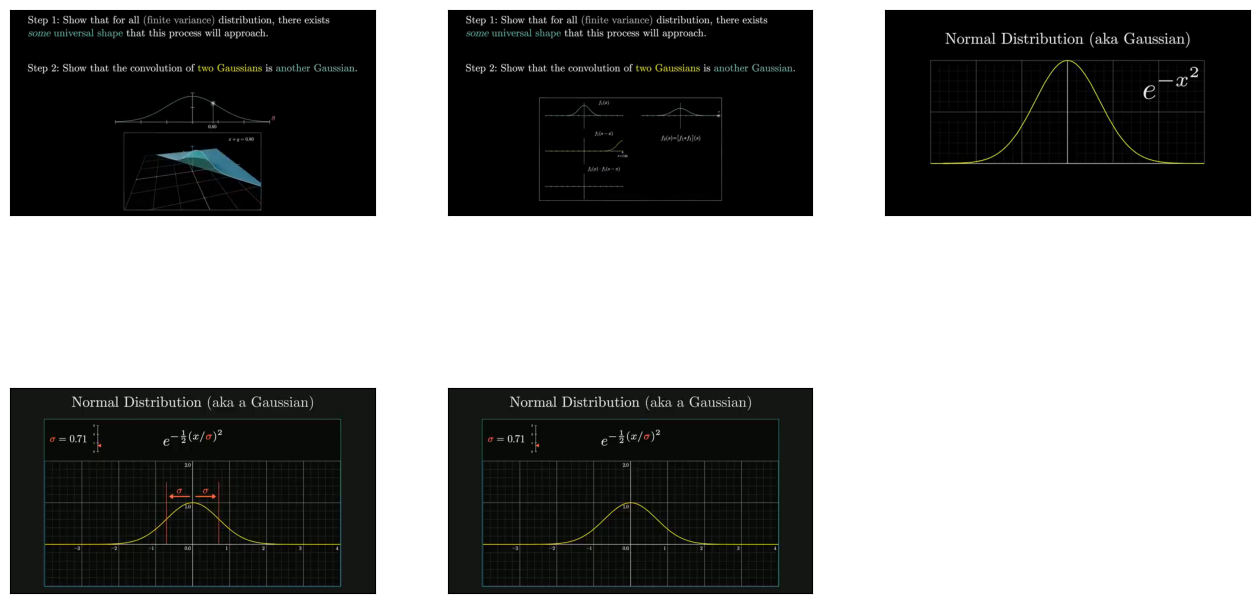

In [75]:
query_str = "tell me more about gaussian function"

img, txt = retrieve(retriever_engine=retriever_engine, query_str=query_str)
image_documents = SimpleDirectoryReader(input_dir=output_folder, input_files=img).load_data()
context_str = "".join(txt)
plot_images(img)
print(txt)

## Generate final response using VLM

[back to top ⬆️](#Table-of-contents:)

### Set the RAG prompt template

[back to top ⬆️](#Table-of-contents:)

In [76]:
qa_tmpl_str = (
    "Given the provided information, including relevant images and retrieved context from the video, \
 accurately and precisely answer the query without any additional prior knowledge.\n"
    "Please ensure honesty and responsibility, refraining from any racist or sexist remarks.\n"
    "---------------------\n"
    "Context: {context_str}\n"
    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

### Initialize VLM

[back to top ⬆️](#Table-of-contents:)

Select inference device

In [77]:
vlm_device = device_widget(default="AUTO", exclude=["NPU"])

vlm_device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

`OpenVINOMultiModal` class provides convenient way for running multimodal model in LlamaIndex. It accepts directory with converted model and inference device as arguments. For running model with streaming we will use `stream_complete` method. For more information about the OpenVINO multimodal models support in LlamaIndex, refer to the [OpenVINOMultiModal Document](https://docs.llamaindex.ai/en/stable/examples/multi_modal/openvino_multimodal/).

In [78]:
from transformers import AutoProcessor, AutoTokenizer

vlm_int4_model_path = "Phi-3.5-vision-instruct/INT4"

processor = AutoProcessor.from_pretrained(vlm_int4_model_path, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(vlm_int4_model_path)


def messages_to_prompt(messages, image_documents):
    """
    Prepares the input messages and images.
    """
    images = []
    placeholder = ""

    for i, img_doc in enumerate(image_documents, start=1):
        images.append(Image.open(img_doc.image_path))
        placeholder += f"<|image_{i}|>\n"
    conversation = [
        {"role": "user", "content": placeholder + messages[0].content},
    ]

    prompt = tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)

    inputs = processor(prompt, images, return_tensors="pt")
    return inputs

In [86]:
from llama_index.multi_modal_llms.openvino import OpenVINOMultiModal

vlm = OpenVINOMultiModal(
    model_id_or_path=vlm_int4_model_path,
    device=vlm_device.value,
    messages_to_prompt=messages_to_prompt,
    generate_kwargs={"do_sample": False, "eos_token_id": processor.tokenizer.eos_token_id},
)

In [87]:
response = vlm.stream_complete(
    prompt=qa_tmpl_str.format(context_str=context_str, query_str=query_str),
    image_documents=image_documents,
)
for r in response:
    print(r.delta, end="")

The Gaussian function, also known as the normal distribution, is a fundamental concept in probability and statistics. It is characterized by its bell-shaped curve, which is symmetric around its mean. The function is defined by the equation e to the negative x squared, where 'e' is the base of the natural logarithm, and 'x' represents the variable. The standard deviation, denoted by 'σ', determines the width of the curve, with a larger 'σ' resulting in a wider curve. The Gaussian function is unique because it is the only distribution that is fully described by its mean and standard deviation, and it has the property that the area under the curve is equal to one, making it a valid probability distribution. The convolution of two Gaussian functions results in another Gaussian function, which is why it is often used in the central limit theorem, a fundamental concept in probability that describes the distribution of the sum of multiple random variables.

## Interactive Demo
[back to top ⬆️](#Table-of-contents:)

Now, you can try to chat with model. Upload video, provide your text message into `Input` field and click `Submit` to start communication.

In [90]:
import gradio as gr


def build_index(video_path):
    """
    callback function for building index of vector store

    Params:
      video_path: path of uploaded video file
    Returns:
      vector store is ready

    """

    global retriever_engine
    progress = gr.Progress()
    progress(None, desc="Video to Images...")
    video_to_images(video_path, output_folder)
    progress(None, desc="Video to Audio...")
    video_to_audio(video_path, output_audio_path)
    progress(None, desc="Audio to Texts...")
    text_data = audio_to_text(output_audio_path)

    with open(output_folder + "output_text.txt", "w") as file:
        file.write(text_data)
    print("Text data saved to file")
    file.close()
    os.remove(output_audio_path)

    progress(0, desc="Building Index...")
    documents = SimpleDirectoryReader(output_folder).load_data()
    client = qdrant_client.QdrantClient(":memory:")

    text_store = QdrantVectorStore(client=client, collection_name="text_collection")
    image_store = QdrantVectorStore(client=client, collection_name="image_collection")
    storage_context = StorageContext.from_defaults(vector_store=text_store, image_store=image_store)
    index = MultiModalVectorStoreIndex.from_documents(
        documents, storage_context=storage_context, image_embed_model=Settings.embed_model, transformations=[SentenceSplitter(chunk_size=500, chunk_overlap=50)]
    )

    retriever_engine = index.as_retriever(similarity_top_k=2, image_similarity_top_k=5)
    return "Vector Store is Ready"


def search(history):
    """
    callback function for searching vector store

    Params:
      history: conversation history
    Returns:
      lists of retrieved images and texts

    """
    progress = gr.Progress()
    progress(None, desc="Searching...")
    img, txt = retrieve(retriever_engine=retriever_engine, query_str=history[-1][0])
    return img, txt


def is_last_element(gen):
    try:
        next(gen)
        return False
    except StopIteration:
        return True


def generate(history, images, texts):
    """
    callback function for running chatbot on submit button click

    Params:
      history: conversation history
      images: list of retrieved images
      texts: list of retrieved texts

    """
    progress = gr.Progress()
    progress(None, desc="Generating...")
    image_documents = SimpleDirectoryReader(input_dir=output_folder, input_files=images).load_data()
    context_str = "".join(texts)

    response = vlm.stream_complete(
        prompt=qa_tmpl_str.format(context_str=context_str, query_str=history[-1][0]),
        image_documents=image_documents,
    )
    partial_text = ""
    for r in response:
        partial_text += r.delta
        if is_last_element(response):
            partial_text += "\n You can find more detailed information in following pictures:"
        history[-1][1] = partial_text
        yield history


def load_image(history, images):
    """
    callback function for loading image gallery

    Params:
      history: conversation history
      images: list of retrieved images
    Returns:
      updated conversation history

    """
    history = history + [[None, ""]]
    history[-1][1] = gr.Gallery(images)
    return history


def stop():
    vlm._model.request.cancel()

**Node ID:** a73271e8-47df-497f-ab73-52d48f1e6d9c<br>**Similarity:** 0.703866796202413<br>**Text:** Which, as you know by now, is the same as asking what do you get if you compute a convolution between two Gaussian functions. I'd like to share an especially pleasing visual way that you can think ...<br>

**Node ID:** c1c3e11b-ce4b-41b6-b461-966b3954a0e3<br>**Similarity:** 0.6901467656899297<br>**Text:** The basic function underlying a normal distribution, aka a Gaussian, is E to the negative x squared. But you might wonder why this function? Of all the expressions we could dream up that give you s...<br>

In [ ]:
if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/multimodal-rag/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo

demo = make_demo(filepath, build_index, search, generate, load_image, stop)

try:
    demo.queue().launch()
except Exception:
    demo.queue().launch(share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/